# Módulo 1: Fundamentos para el desarrollo de servicios analíticos

## Ajuste de entorno:

1. Instalar UV en ambiente base (pip install uv)

2. Clonar repositorio de github: https://github.com/bricj/Credibanco.git

3. ubicarse en la ruta e indicar: "uv sync" o instalar dependencias con "uv add"

4. Garantizar tener instalado ipykernel: "uv add ipykernel"

5. Registrar el entorno en caso que el kernel no se reconozca:

    python -m ipykernel install --user --name=credibanco-env --display-name "Python (Credibanco)"


## Contexto:

En la presente sesión se abordará el uso e implementación de APIs en los procesos de analítica de datos, a través del dataset "NFT-70M_transactions".

Este conjunto de datos, contiene información desde 2021 a 2023 y cuenta con más de 70 millones de registros, proviene de OpenSea y ofrece una vista comprensiva del universo de transacciones de Tokens No Fungibles (NFT).

La pregunta problema a resolver en el siguiente ejercicio es: ¿Cuales son las relaciones transaccionales entre las redes blockchain y sus respectivos tokens?



### Características del Dataset
El "NFT-70M_transactions" es un dataset multimodal que incluye información detallada sobre transacciones, tales como identificadores de NFT, número de ventas, información de precios, entre otros. Es importante mencionar que para preservar la privacidad y cumplir con normativas, la información sensible ha sido anonimizada y las imágenes o descripciones se ofrecen como embeddings.

### Objetivos de aprendizaje
A través de este dataset, se realizará: 

- Importar datos de una fuente pública de datos (API).
- Procesamiento de datos.
- Disponibilización de información a través de FASTAPI.

El dataset está disponible en: https://huggingface.co/datasets/MLNTeam-Unical/NFT-70M_transactions


### Campos de Datos del Dataset

| Variable                 | Tipo        | Descripción                                                                                        | Procesamiento | Notas                                           |
|--------------------------|-------------|----------------------------------------------------------------------------------------------------|---------------|-------------------------------------------------|
| token_id                 | String      | El id del NFT — este valor es único dentro de la misma colección                                   | Anonimizado   | Los valores originales fueron reemplazados por códigos hash |
| num_sales                | Integer     | Un entero progresivo que indica el número de transacciones exitosas que involucran el NFT hasta el momento actual (cf. tx_timestamp) | Original      | Variable no sensible                            |
| nft_name                 | Vector ID   | El nombre del NFT                                                                                  | Anonimizado   | Los valores originales fueron cifrados mediante embedding textual neuronal |
| nft_description          | Vector ID   | La descripción del NFT proporcionada por el creador                                                | Anonimizado   | Los valores originales fueron cifrados mediante embedding textual neuronal |
| nft_image                | Vector ID   | El ID para acceder al vector de imagen del NFT                                                     | Anonimizado   | Los valores originales fueron cifrados mediante embedding visual neuronal |
| collection_name          | Vector ID   | El ID para acceder al vector del nombre de la Colección                                            | Anonimizado   | Los valores originales fueron cifrados mediante embedding textual neuronal |
| collection_description   | Vector ID   | El ID para acceder al vector de la descripción de la Colección                                     | Anonimizado   | Los valores originales fueron cifrados mediante embedding textual neuronal |
| collection_image         | Vector ID   | El ID para acceder al vector de la imagen de la Colección                                          | Anonimizado   | Los valores originales fueron cifrados mediante embedding visual neuronal |
| fees_seller              | Float       | La cantidad absoluta de tarifas que el vendedor ha ganado de esta transacción expresada en token   | Original      | Variable no sensible                            |
| fees_opensea             | Float       | La cantidad absoluta de tarifas que OpenSea ha ganado de esta transacción expresada en token       | Original      | Variable no sensible                            |
| fees_seller_usd          | Float       | La cantidad absoluta de tarifas que el vendedor ha ganado de esta transacción expresada en dólares estadounidenses (USD) | Original      | Variable no sensible                            |
| fees_opensea_usd         | Float       | La cantidad absoluta de tarifas que OpenSea ha ganado de esta transacción expresada en dólares estadounidenses (USD) | Original      | Variable no sensible                            |
| payout_collection_address| String      | La dirección de la billetera donde se depositan las tarifas del vendedor                          | Anonimizado   | Los valores originales fueron reemplazados por códigos hash |
| tx_timestamp             | String      | Marca de tiempo de la transacción expresada en yyyy-mm-ddTHH:MM:SS                                 | Original      | Variable no sensible                            |
| price                    | Float       | El precio de la transacción expresado en token                                                     | Original      | Variable no sensible                            |
| gain                     | Float       | La ganancia después de tarifas (es decir, ganancia = precio - tarifas_opensea * precio - tarifas_vendedor * precio) | Original      | Variable no sensible                            |
| usd_price                | Float       | El precio de la transacción expresado en dólares estadounidenses (USD)                             | Original      | Variable no sensible                            |
| usd_gain                 | Float       | La diferencia entre el precio y las tarifas expresada en dólares estadounidenses (USD)             | Original      | Variable no sensible                            |
| token                    | Categorical | El tipo de token utilizado para pagar la transacción                                                | Original      | Variable no sensible                            |
| to_eth                   | Float       | La tasa de conversión para convertir tokens en Ethereum en el momento actual, de tal manera que eth = precio * to_eth | Original      | Variable no sensible                            |
| to_usd                   | Float       | La tasa de conversión para convertir tokens en dólares estadounidenses (USD) en el momento actual, de tal manera que usd = precio * to_usd | Original      | Variable no sensible                            |
| from_account             | String      | La dirección que envía el pago (es decir, ganador/comprador)                                       | Anonimizado   | Los valores originales fueron reemplazados por códigos


## Configuración del entorno: 

En el presente bloque se importan todas las librerías necesarias para dar cumplimiento al objetivo de la presente sesión.

In [21]:
import requests # Librería para hacer peticiones http
from io import BytesIO # Librería para crear objetos en memoria, el objeto está en formato byte
import pandas as pd # Librería para procesar tablas de datos
import numpy as np # Librería para procesamiento numérico
import matplotlib.pyplot as plt # Librería para generar gráficos
import seaborn as sns # Librería para generar gráficos

## Extracción y exploración de datos

Pandas facilita la carga de datos desde una variedad de fuentes como archivos CSV, Excel, Parquet, bases de datos SQL, entre otros. [Para este ejemplo, cargaremos datos desde un archivo `parquet`.

In [22]:
## Tiempo de lectura de datos: 1 Minuto aprox 

# Definir URL
url = 'https://huggingface.co/datasets/MLNTeam-Unical/NFT-70M_transactions/resolve/main/data/train-00000-of-00010-d56ed38e4e0b0874.parquet?download=true'

# Hacer el requerimiento con la URL y leer el formato de los datos
r = requests.get(url)
data = BytesIO(r.content)
df = pd.read_parquet(data)

# Mostrar las primeras filas del dataframe para verificar la carga
df.head()

,token_id,num_sales,nft_name,nft_description,nft_image,collection_name,collection_description,collection_image,fees_seller,fees_opensea,...,from_account,to_account,seller_account,winner_account,contract_address,created_date,chain,token_type,asset_contract_type,asset_type
0,9505411,27,11819168,22381642,23032872,16053997,22381642,7868502,0.00015,0.000750,...,5210808,2126811,3447961,5210808,1991117,2021-08-11T02:56:18.366467,matic,ERC1155,semi-fungible,simple
1,4934239,2,29623742,30615787,24760493,7106257,2012895,121171,0.02350,0.011750,...,458496,5823345,458496,4332284,1522461,2022-08-16T16:54:20.573253,avalanche,ERC721,non-fungible,simple
2,4942906,1,9436321,22381642,16887538,27289515,10344956,22121514,0.00175,0.000875,...,6349957,2126811,428474,6349957,5950043,2023-02-27T07:53:23.425737,ethereum,ERC721,non-fungible,simple
3,3919953,1,6305759,22381642,9224405,27289515,10344956,22121514,0.00175,0.000875,...,6349957,2126811,428474,6349957,5950043,2023-02-27T07:53:23.425737,ethereum,ERC721,non-fungible,simple
4,4406435,1,3055544,22381642,14164189,27289515,10344956,22121514,0.00175,0.000875,...,6349957,2126811,2896100,6349957,5950043,2023-02-27T07:53:23.425737,ethereum,ERC721,non-fungible,simple


In [23]:
# Validación tamaño del dataset
print(df.shape)

(7097215, 31)


In [24]:
# Validacion de columnas y tipo de datos
print(f"{df.columns}\n")
df.info()

Index(['token_id', 'num_sales', 'nft_name', 'nft_description', 'nft_image',
       'collection_name', 'collection_description', 'collection_image',
       'fees_seller', 'fees_opensea', 'fees_seller_usd', 'fees_opensea_usd',
       'payout_collection_address', 'tx_timestamp', 'price', 'gain',
       'usd_price', 'usd_gain', 'token', 'to_eth', 'to_usd', 'from_account',
       'to_account', 'seller_account', 'winner_account', 'contract_address',
       'created_date', 'chain', 'token_type', 'asset_contract_type',
       'asset_type'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7097215 entries, 0 to 7097214
Data columns (total 31 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   token_id                   int64  
 1   num_sales                  int64  
 2   nft_name                   int64  
 3   nft_description            int64  
 4   nft_image                  int64  
 5   collection_name            int64  
 6   

In [25]:
# Crear copia de un dataframe para que no se altere el dataframe original
df_sample = df.copy()

# Obtener una muestra aleatorio de 1000 registros (la muestra aleatorio inicia 
    # en la semilla 42 para replicar resultados)
df_sample = df_sample.sample(n=300000, random_state=42)

In [26]:
# Resumen estadística descriptiva
df_sample.describe()

,token_id,num_sales,nft_name,nft_description,nft_image,collection_name,collection_description,collection_image,fees_seller,fees_opensea,...,gain,usd_price,usd_gain,to_eth,to_usd,from_account,to_account,seller_account,winner_account,contract_address
count,3.000000e+05,300000.000000,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,300000.000000,300000.000000,...,300000.000000,300000.000000,300000.000000,3.000000e+05,300000.000000,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05,3.000000e+05
mean,5.637023e+06,908.599667,1.613575e+07,1.697239e+07,1.410213e+07,1.568434e+07,1.645534e+07,1.388843e+07,0.619315,0.224456,...,8.523264,711.968036,668.879518,7.163601e-01,1299.304307,3.345161e+06,2.597282e+06,3.138032e+06,3.193014e+06,2.927801e+06
std,3.146717e+06,6034.048377,8.953278e+06,8.379242e+06,7.757751e+06,9.233895e+06,9.006192e+06,7.899330e+06,41.625564,10.916366,...,384.892028,7975.919144,7637.735898,4.415835e-01,801.024218,1.864375e+06,1.297678e+06,1.804587e+06,1.865646e+06,1.936727e+06
min,2.450000e+02,0.000000,1.400000e+01,6.300000e+01,1.460000e+02,4.209000e+03,1.895000e+03,6.134000e+03,0.000000,0.000000,...,0.000000,0.000000,0.000000,7.714180e-07,0.001395,2.800000e+01,9.476000e+03,6.800000e+01,2.800000e+01,4.840000e+02
25%,2.932109e+06,1.000000,8.601965e+06,1.066277e+07,7.725251e+06,7.571550e+06,8.435301e+06,6.959091e+06,0.000000,0.000162,...,0.010725,4.656376,4.429035,1.715038e-01,308.720000,1.702754e+06,2.126811e+06,1.742218e+06,1.574983e+06,1.146682e+06
50%,5.701358e+06,3.000000,1.664573e+07,1.962475e+07,1.458951e+07,1.553232e+07,1.688050e+07,1.464035e+07,0.001133,0.000925,...,0.051625,34.719650,32.132160,1.000000e+00,1808.750000,3.445007e+06,2.126811e+06,2.964276e+06,3.192620e+06,3.004016e+06
75%,8.519570e+06,7.000000,2.294848e+07,2.238164e+07,2.018941e+07,2.396203e+07,2.327350e+07,2.054236e+07,0.008406,0.005500,...,0.370000,154.763963,143.824275,1.000000e+00,1821.210000,5.106374e+06,2.985804e+06,4.687619e+06,4.815621e+06,4.483636e+06
max,1.088792e+07,61386.000000,3.174964e+07,3.174955e+07,2.722801e+07,3.174545e+07,3.174873e+07,2.722322e+07,13500.000000,3375.000000,...,118125.000000,974437.860000,950076.913500,1.000000e+00,1829.200000,6.422389e+06,6.383163e+06,6.422408e+06,6.422389e+06,6.422438e+06


In [27]:
# Selección de variables objetivo apra atender la pregunta problema
df_sample = df_sample[[
    "token_id", "num_sales", "fees_seller_usd", "fees_opensea_usd", 
    "tx_timestamp", "usd_price", "usd_gain", "token", "chain", "token_type", "from_account", "to_account"
]]


In [28]:
# Convertir campo fecha a formato fecha
df_sample['tx_timestamp'] = pd.to_datetime(df_sample['tx_timestamp'])
df_sample['month'] = df_sample['tx_timestamp'].dt.to_period('M')


In [29]:
# Exploración categoría "Chain"
print("Distribución por blockchain (chain):")
print(df_sample['chain'].value_counts())


Distribución por blockchain (chain):
chain
ethereum         177721
matic             52540
solana            24272
arbitrum          16138
bsc               15056
arbitrum_nova      8728
optimism           2571
avalanche          2223
klaytn              751
Name: count, dtype: int64


In [30]:
# Exploración categoría "Token"
print("\nDistribución por tipo de token (token):")
print(df_sample['token'].value_counts())


Distribución por tipo de token (token):
token
ETH        155074
WETH        56928
MATIC       41364
SOL         24272
BNB         12514
WBNB         2542
USDC         1770
WAVAX        1676
MAGIC        1628
KLAY          643
AVAX          547
DAI           432
GALA_V1       268
SAND          202
WKLAY         108
REVV           18
MANA            7
ASH             3
APE             2
LINK            1
NCT             1
Name: count, dtype: int64


## Creación de redes transaccionales por "Chain", "Token" y "Monto en USD"

Un DAG (Directed Acyclic Graph, en español: grafo dirigido acíclico) es una estructura de datos compuesta por nodos conectados por aristas dirigidas, con la condición clave de que no existen ciclos; es decir, no puedes empezar en un nodo y, siguiendo las aristas en su dirección, volver al mismo nodo.

**Aspectos relevantes de los DAGs en el contexto transaccional**

1. Representación de flujo unidireccional
Transacciones tienen una dirección natural:

    De un comprador a un vendedor.

    De una wallet a otra.

    De un token a una chain.

    Un DAG permite modelar esa dirección sin ambigüedades y sin ciclos redundantes.

2. Evita ciclos infinitos en análisis

    Si estás analizando transacciones para encontrar patrones, flujos de valor, detección de fraude o lavado de dinero, los ciclos pueden introducir errores o bucles infinitos. Usar un DAG garantiza que el análisis puede avanzar de forma ordenada (topológica).

3. Orden topológico

    En un DAG, se puede realizar un ordenamiento topológico de los nodos. Esto es muy útil para:

    Determinar secuencia temporal de eventos.

    Estimar causas → consecuencias.

    Organizar pasos en pipelines o flujos de datos.

4. Trazabilidad de activos

    En sistemas financieros o blockchain, un DAG permite trazar el origen de un token o activo desde su creación hasta su último movimiento, lo cual es crucial para auditoría, cumplimiento normativo o seguridad.

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_24128\3459897478.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


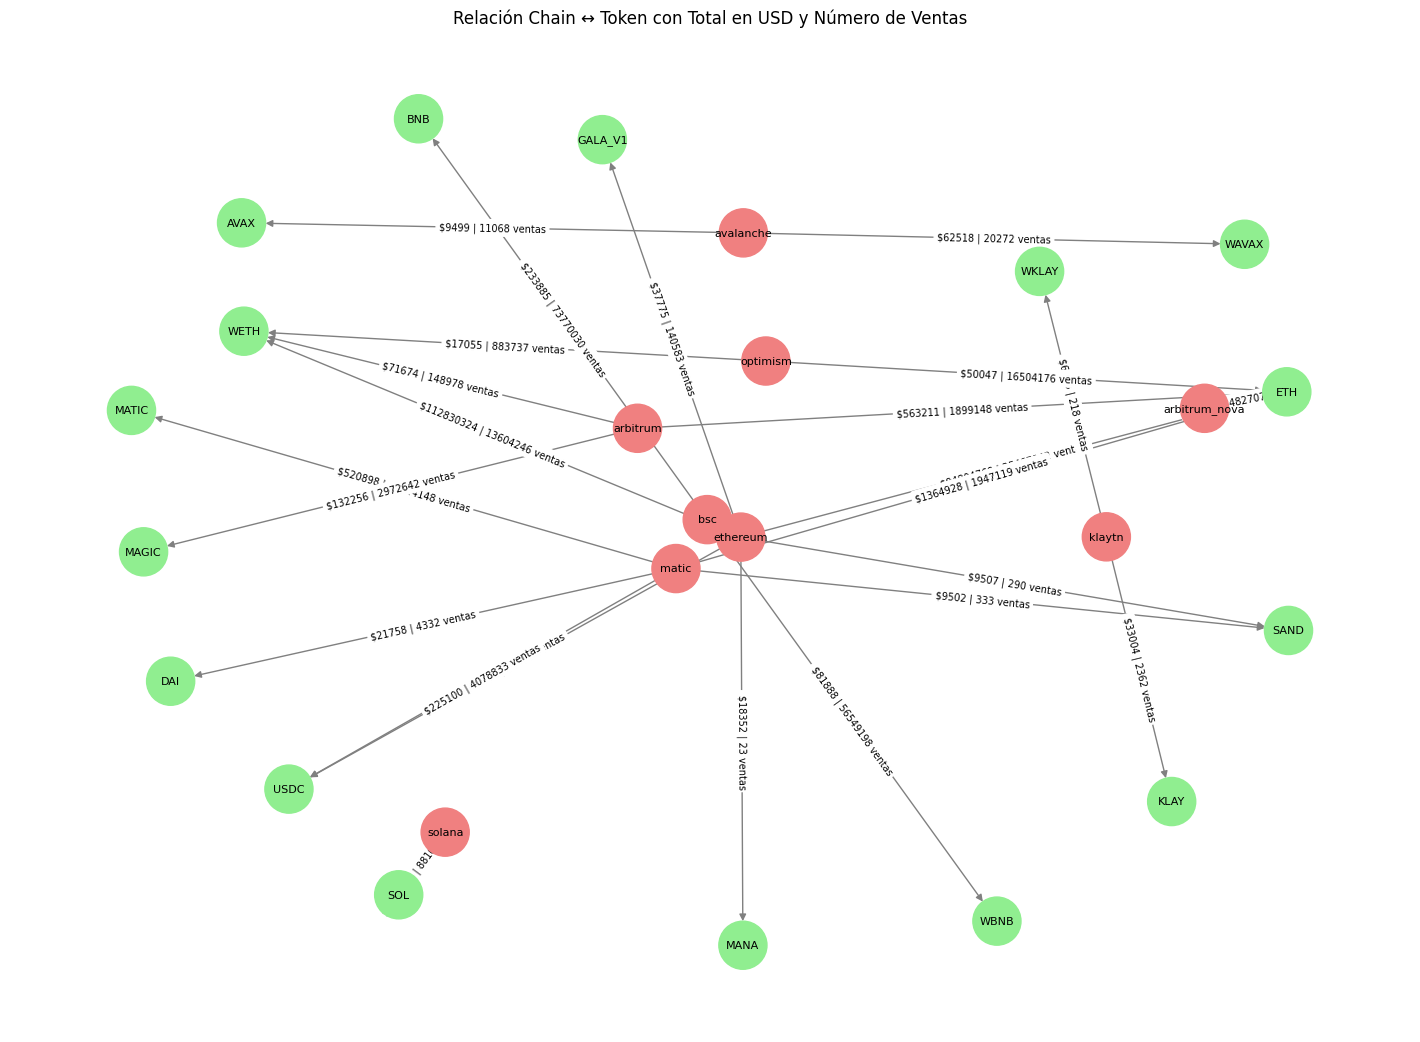

In [31]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

# Crear un grado dirigido, donde los nodos son "chains" y "tokens". Las relaciones se establecen entre 
    # las redes y los tokens
G_chain_token = nx.DiGraph()

# Se crea un diccionario para consolidar la información de precio en dolares y numero de ventas
agg_data = defaultdict(lambda: {"usd_price": 0.0, "num_sales": 0})

# Se recorre el dataframe para consolidar la información por "chain" y "token"
for _, row in df_sample.iterrows():
    chain = row.get("chain", "N/A")
    token = row.get("token", "N/A")
    usd_price = row.get("usd_price", 0.0)
    num_sales = row.get("num_sales", 0)

    # Las variables número de transacciones y monto en dolares de transacciones se acumula 
    if chain != "N/A" and token != "N/A":
        agg_data[(chain, token)]["usd_price"] += usd_price
        agg_data[(chain, token)]["num_sales"] += num_sales

# De manera iterativa se adicionan relaciones entre los nodos y aristas.
# Se considera un umbral de 5000 dólares para filtrar el volumen de transacciones
for (chain, token), values in agg_data.items():
    if values["usd_price"] > 5000:  # umbral
        G_chain_token.add_node(chain, type="chain")
        G_chain_token.add_node(token, type="token")
        G_chain_token.add_edge(
            chain, token,
            usd_price=values["usd_price"],
            num_sales=values["num_sales"]
        )

# Visualización del grafo (Spring layout permite ubicar los nodos de forma automática)
pos = nx.spring_layout(G_chain_token, seed=42)
plt.figure(figsize=(14, 10))

# Se añaden colores para distinguir entre nodos y aristas
node_colors = ['lightcoral' if G_chain_token.nodes[n]["type"] == "chain" else 'lightgreen' for n in G_chain_token.nodes]

# Dibujar nodos y aristas
nx.draw(G_chain_token, pos, with_labels=True, node_color=node_colors, node_size=1200, edge_color='gray', font_size=8)

# Agregar etiquetas para la variables precio en dólares y volumen de ventas
edge_labels = {
    (u, v): f"${d['usd_price']:.0f} | {d['num_sales']} ventas"
    for u, v, d in G_chain_token.edges(data=True)
}
nx.draw_networkx_edge_labels(G_chain_token, pos, edge_labels=edge_labels, font_size=7)

plt.title("Relación Chain ↔ Token con Total en USD y Número de Ventas")
plt.axis("off")
plt.tight_layout()
plt.show()


## Implementación FASTAPI

In [ ]:
from fastapi import FastAPI, Query, HTTPException # Importa FASTAPI para crear la API y query para definir parametros de consulta
from collections import defaultdict # Permite crear colecciones en formato de diccionario
import networkx as nx # librería para trabajar con grafos y redes.
import nest_asyncio # Permite ejecutar funciones asíncronas como FASTAPI en Jupyter Notebook
import uvicorn # Servidor ASGI que corre FastAPI.
from threading import Thread # Permite ejecutar el servidor en un hilo separado y no bloquear el notebook.
from pydantic import BaseModel
from typing import Optional
import pandas as pd # Librería para procesar tablas de datos
import numpy as np # Librería para procesamiento numérico

nest_asyncio.apply() # Aplica un parche para permitir que asyncio corra 
                        # dentro del entorno de Jupyter sin conflicto de bucles de eventos.

app = FastAPI() # Se instancia FASTAPI (Activar la clase (OOP) de FASTAPI)

## Construcción del grafo
# def build_graph(threshold=5000):
#     G = nx.DiGraph()
#     agg_data = defaultdict(lambda: {"usd_price": 0.0, "num_sales": 0})

#     for _, row in df_sample.iterrows():
#         chain = row.get("chain", "N/A")
#         token = row.get("token", "N/A")
#         usd_price = row.get("usd_price", 0.0)
#         num_sales = row.get("num_sales", 0)

#         if chain != "N/A" and token != "N/A":
#             agg_data[(chain, token)]["usd_price"] += usd_price
#             agg_data[(chain, token)]["num_sales"] += num_sales

#     for (chain, token), values in agg_data.items():
#         if values["usd_price"] > threshold:
#             G.add_node(chain, type="chain")
#             G.add_node(token, type="token")
#             G.add_edge(
#                 chain, token,
#                 usd_price=values["usd_price"],
#                 num_sales=values["num_sales"]
#             )
#     return G

def build_graph(threshold=5000):
    G = nx.DiGraph()
    agg_data = defaultdict(lambda: {"usd_price": 0.0, "num_sales": 0})
    edges_list = []

    for _, row in df_sample.iterrows():
        chain = row.get("chain", "N/A")
        token = row.get("token", "N/A")
        usd_price = row.get("usd_price", 0.0)
        num_sales = row.get("num_sales", 0)

        if chain != "N/A" and token != "N/A":
            agg_data[(chain, token)]["usd_price"] += usd_price
            agg_data[(chain, token)]["num_sales"] += num_sales

    for (chain, token), values in agg_data.items():
        if values["usd_price"] > threshold:
            G.add_node(chain, type="chain")
            G.add_node(token, type="token")
            G.add_edge(
                chain, token,
                usd_price=values["usd_price"],
                num_sales=values["num_sales"]
            )
            # Agregar al listado para el DataFrame
            edges_list.append({
                "from": chain,
                "to": token,
                "usd_price": round(values["usd_price"], 2),
                "num_sales": values["num_sales"]
            })

    # Convertir a DataFrame
    df_edges = pd.DataFrame(edges_list)

    return G, df_edges

# Se construye el grafo sobre el dataframe df_sample
#G_chain_token = build_graph()
G_chain_token, df_edges = build_graph()

# ----------------- Esquemas -----------------
# Los esquemas son modelos de datos que se utilizan para validar, documentar y 
    # estructurar la información que entra o sale de la API."

class Relation(BaseModel):
    chain: str
    token: str
    usd_price: float
    num_sales: int

class PartialRelation(BaseModel):
    chain: str
    token: str
    usd_price: Optional[float] = None
    num_sales: Optional[int] = None

class DeleteRelation(BaseModel):
    chain: str
    token: str

# ----------------- Endpoints -----------------

# Decorador -> @ : Método para añadir funcionalidades a una función
# A la función del endpoint se le adiciona la funcionalidad que se requiere.

@app.get("/network")
def get_network(
    from_node: str = Query(None, description="Filtrar por nodo origen"),
    to_node: str = Query(None, description="Filtrar por nodo destino")
):

    """
    Retorna todas las relaciones (aristas) del grafo, con opción de filtrar por nodo origen (from) y nodo destino (to).
    """
    edges = [
        {
            "from": u,
            "to": v,
            "usd_price": round(data["usd_price"], 2),
            "num_sales": data["num_sales"]
        }
        for u, v, data in G_chain_token.edges(data=True)
        if (from_node is None or from_node.lower() == u.lower()) and
           (to_node is None or to_node.lower() == v.lower())
    ]
    return {"edges": edges}

@app.get("/network/search")
def search_network(query: str = Query(..., description="Nombre de chain o token")):
    """Permite buscar cualquier relación que contenga ese string en el chain o el token
    
        Recorre las aristas del grafo buscando coincidencias con el texto buscado (case-insensitive).
    
        Agrega coincidencias a la lista results
    """

    results = []
    for u, v, data in G_chain_token.edges(data=True):
        if query.lower() in u.lower() or query.lower() in v.lower():
            results.append({
                "from": u,
                "to": v,
                "usd_price": round(data["usd_price"], 2),
                "num_sales": data["num_sales"]
            })
    return {"results": results}

@app.post("/network")
def add_relation(data: Relation):

    """Permite agregar una nueva arista entre un chain y token """

    chain = data.chain
    token = data.token
    usd_price = data.usd_price
    num_sales = data.num_sales

    if G_chain_token.has_edge(chain, token):
        raise HTTPException(status_code=400, detail="La relación ya existe")

    G_chain_token.add_node(chain, type="chain")
    G_chain_token.add_node(token, type="token")
    G_chain_token.add_edge(chain, token, usd_price=usd_price, num_sales=num_sales)
    return {"message": "Relación agregada correctamente"}

@app.put("/update_relation")
def update_relation(data: Relation):

    """
     Actualiza toda la relación entre chain y token.
    Se sobrescriben completamente los datos existentes.
    """
    if G_chain_token.has_edge(data.chain, data.token):
        G_chain_token[data.chain][data.token]["usd_price"] = data.usd_price
        G_chain_token[data.chain][data.token]["num_sales"] = data.num_sales
        return {"message": "Relación actualizada exitosamente"}
    else:
        raise HTTPException(status_code=404, detail="Relación no encontrada")

@app.patch("/update_relation")
def patch_relation(data: PartialRelation):
    """ 
    Permite actualizar los campos proporcionados.
    """
    if not G_chain_token.has_edge(data.chain, data.token):
        raise HTTPException(status_code=404, detail="Relación no encontrada")

    if data.usd_price is not None:
        G_chain_token[data.chain][data.token]["usd_price"] = data.usd_price
    if data.num_sales is not None:
        G_chain_token[data.chain][data.token]["num_sales"] = data.num_sales

    return {"message": "Relación modificada parcialmente"}

@app.delete("/network")
def delete_relation(data: DeleteRelation):
    """ 
    Elimina la relación chain → token.
    """
    if not G_chain_token.has_edge(data.chain, data.token):
        raise HTTPException(status_code=404, detail="Relación no encontrada")
    
    G_chain_token.remove_edge(data.chain, data.token)
    return {"message": "Relación eliminada correctamente"}

# ----------------- Ejecutar -----------------
def start():
    """ 
    Define la función start, que lanza el servidor FastAPI usando uvicorn.
    Usa el host 127.0.0.1 (localhost) y el puerto 8888.
    app es la instancia de FastAPI.
    uvicorn.run() bloquea el hilo actual, por eso se lanza en un hilo separado si estás en Jupyter.
    """

    uvicorn.run(app, host="127.0.0.1", port=8080)

# Permite ejecución en paralelo para no generar conflicto entre jupyter notebook y FASTAPI
thread = Thread(target=start)
thread.start()



INFO:     Started server process [24128]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8080 (Press CTRL+C to quit)


INFO:     127.0.0.1:60887 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:60887 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:60898 - "PUT /update_relation HTTP/1.1" 200 OK
INFO:     127.0.0.1:60902 - "PATCH /update_relation HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:60903 - "PATCH /update_relation HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:60904 - "PATCH /update_relation HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:60910 - "PATCH /update_relation HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:60911 - "PATCH /update_relation HTTP/1.1" 200 OK
INFO:     127.0.0.1:60915 - "GET /network?from_node=ethereum HTTP/1.1" 200 OK
INFO:     127.0.0.1:60916 - "GET /network?from_node=ethereum HTTP/1.1" 200 OK
INFO:     127.0.0.1:60916 - "GET /favicon.ico HTTP/1.1" 404 Not Found


### Visualización tabla de datos

In [36]:
df_edges

,from,to,usd_price,num_sales
0,ethereum,ETH,9.480476e+07,25467942
1,matic,MATIC,5.208981e+05,69644148
2,bsc,BNB,2.338848e+05,73770030
3,solana,SOL,2.426536e+06,88162
4,ethereum,WETH,1.128303e+08,13604246
5,matic,ETH,1.364928e+06,1947119
6,arbitrum_nova,ETH,1.164635e+04,4827072
7,bsc,WBNB,8.188762e+04,56549198
8,matic,USDC,2.251004e+05,4078833
9,arbitrum,ETH,5.632107e+05,1899148


### Consulta con URL

In [37]:
"http://127.0.0.1:8080/network?from_node=ethereum"

'http://127.0.0.1:8080/network?from_node=ethereum'

## Actividad

- En la carpeta activity encontrará un archivo python llamado "data.api.py". Levante el servicio de la api y realice la lectura de datos.

URL para leer datos: http://127.0.0.1:9000/iris

Se debe indicar la URL en una variable e implementar request.get(url). Guardar resultado en una variable

- Al anterior resultado (ejemplo variable response), guardar en una variable "response.json()".

- La variable guardada previamente, incluirla en un método pd.DataFrame:
    EJ: pd.DataFrame(data)

- Considere la información obtenida, realice la lectura de datos, procese la información de tal manera que se genere un resumen de los datos (agrupamiento mediante group by - misma lógica que las tablas dinámica) y disponibilizar la información en fastapi para consulta en el puerto 8980.



### Respuesta en caso de sentirse estancado

**Ejemplo lectura de datos**

import requests
import pandas as pd

url = "http://127.0.0.1:8000/iris"

response = requests.get(url)

if response.status_code == 200:

    data = response.json()

    df = pd.DataFrame(data)
    
    #print(df.head())
else:
    print("Error al obtener los datos:", response.status_code)

**Ejempleo GroupBY Agrupar por especie y tamaño de sépalo**

grouped = df.groupby(["species", "sepal_size"]).agg(["mean", "std"])